# Dataloader

In [73]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
from typing import Dict, List, Tuple, Union

class CubeData(Dataset):
    """Cube Dataset with Stride-based Patch Extraction and Optional Normalization"""
    def __init__(self, root: str, name: str, patch_size: int = 128, stride: int = 64, 
                 transform=None, folder=True, file=None, apply_normalization=True) -> None:
        """
        Create a dataset from a given directory with stride-based patch extraction.
        
        Args:
            root (str): Root directory path
            name (str): Name of the dataset/subdirectory
            patch_size (int): Size of patches to extract (default: 128)
            stride (int): Stride for patch extraction (default: 64)
            transform: Optional transform to be applied on patches
            folder (bool): If True, load all .npy files from directory. If False, load single file
            file (str): Specific file to load when folder=False
            apply_normalization (bool): If True, normalize patches using dataset mean and std
        """
        super().__init__()
        self.transform = transform
        self.root = root
        self.name = name
        self.patch_size = patch_size
        self.stride = stride
        self.apply_normalization = apply_normalization

        # Handle both folder and single file cases
        if folder:
            self.cubeFileNames = [f for f in os.listdir(os.path.join(self.root, name, "python")) 
                                if ".npy" in f]
        else:
            if file is None:
                raise ValueError("When folder=False, a file name must be provided!")
            self.cubeFileNames = [file]

        if len(self.cubeFileNames) == 0:
            raise ValueError("Couldn't find any numpy files in the given folder!")

        self.cubes = self.__load_cubes()
        self.patches, self.patch_positions = self.__extract_patches()
        self.file_patch_mapping = self.__create_file_patch_mapping()
        
        # Compute mean and std for normalization
        if self.apply_normalization:
            self.mean, self.std = self.__compute_mean_and_std()
            print(f"Dataset mean: {self.mean}")
            print(f"Dataset std: {self.std}")
        else:
            self.mean, self.std = None, None

    def __compute_mean_and_std(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute mean and standard deviation directly from patches.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean and standard deviation for each channel
        """
        patches_tensor = torch.stack([torch.from_numpy(patch) for patch in self.patches])
        mean = patches_tensor.mean(dim=(0, 2, 3))
        std = patches_tensor.std(dim=(0, 2, 3), unbiased=False)
        return mean, std

    def __load_and_reshape(self, file_path):
        """Load and reshape the cube data to ensure proper dimensionality."""
        current_cube = np.load(file_path)
        if current_cube.ndim == 2:
            current_cube = np.expand_dims(current_cube, axis=0).astype(np.float32)
        return current_cube

    def __load_cubes(self) -> Dict[str, np.ndarray]:
        """Loads all cubes contained in the folder and stores them in a dictionary indexed by filename."""
        cubes = {}
        total_size = 0
        for file in self.cubeFileNames:
            file_path = os.path.join(self.root, self.name, "python", file)
            current_cube = self.__load_and_reshape(file_path)
            fileName = file.split('.')[0]
            cubes[fileName] = current_cube
            total_size += current_cube.nbytes
        print(f"Total size of loaded cubes: {total_size / (1024**3):.2f} GB")
        return cubes

    def __extract_patches(self):
        """Extract patches from each cube using the specified patch size and stride."""
        patches = []
        patch_positions = []
        for file_name, cube in self.cubes.items():
            c, H, W = cube.shape
            for i in range(0, H - self.patch_size + 1, self.stride):
                for j in range(0, W - self.patch_size + 1, self.stride):
                    patch = cube[:, i:i+self.patch_size, j:j+self.patch_size]
                    patches.append(patch)
                    patch_positions.append((file_name, j, j+self.patch_size, i, i+self.patch_size))
        return patches, patch_positions

    def __create_file_patch_mapping(self):
        """Creates a mapping of which patches belong to which file."""
        mapping = {}
        for idx, (file_name, _, _, _, _) in enumerate(self.patch_positions):
            if file_name not in mapping:
                mapping[file_name] = []
            mapping[file_name].append(idx)
        return mapping

    def __len__(self) -> int:
        """Returns the total number of patches."""
        return len(self.patches)

    def __normalize(self, patch: torch.Tensor) -> torch.Tensor:
        """Normalize the patch using computed mean and std."""
        if self.apply_normalization:
            return (patch - self.mean[:, None, None]) / (self.std[:, None, None] + 1e-8)
        return patch

    def __getitem__(self, index: Union[int, List[int], slice]) -> Tuple[torch.Tensor, torch.Tensor, Union[Dict, List[Dict]]]:
        """
        Returns normalized patch(es), corresponding mask(s), and position information.
        """
        if isinstance(index, (torch.Tensor, np.ndarray)):
            index = index.tolist()

        if isinstance(index, int):
            patch = torch.from_numpy(self.patches[index].copy())
            position_info = {
                'file_name': self.patch_positions[index][0],
                'xmin': self.patch_positions[index][1],
                'xmax': self.patch_positions[index][2],
                'ymin': self.patch_positions[index][3],
                'ymax': self.patch_positions[index][4]
            }
            
        elif isinstance(index, list):
            patch = torch.stack([torch.from_numpy(self.patches[i].copy()) for i in index])
            position_info = [{
                'file_name': self.patch_positions[i][0],
                'xmin': self.patch_positions[i][1],
                'xmax': self.patch_positions[i][2],
                'ymin': self.patch_positions[i][3],
                'ymax': self.patch_positions[i][4]
            } for i in index]
            
        elif isinstance(index, slice):
            indices = range(index.start or 0, index.stop or len(self), index.step or 1)
            patch = torch.stack([torch.from_numpy(self.patches[i].copy()) for i in indices])
            position_info = [{
                'file_name': self.patch_positions[i][0],
                'xmin': self.patch_positions[i][1],
                'xmax': self.patch_positions[i][2],
                'ymin': self.patch_positions[i][3],
                'ymax': self.patch_positions[i][4]
            } for i in indices]

        patch = self.__normalize(patch)

        if self.transform:
            patch = self.transform(patch)

        mask = self.__computeMask(patch).to(torch.bool)
        patch = torch.nan_to_num(patch, nan=0.0)
        
        return patch, mask, position_info

    def __computeMask(self, img: torch.Tensor) -> torch.Tensor:
        """Computes a binary mask for a given patch."""
        mask = torch.zeros_like(img)
        mask[torch.where(img == 0)] = 1.0
        if torch.isnan(img).any():
            mask[torch.isnan(img)] = 1.0
        if len(img.shape) == 3:
            c, h, w = img.shape
            summed = torch.sum(mask, dim=0)
            mask = (summed == c).unsqueeze(0).float()
        else:
            n, c, h, w = img.shape
            summed = torch.sum(mask, dim=1)
            mask = (summed == c).unsqueeze(1).float()
        return mask

    def get_patches_for_file(self, file_name: str) -> List[int]:
        """Returns indices of all patches that belong to a specific file."""
        file_name = file_name.replace('.npy', '')
        return self.file_patch_mapping.get(file_name, [])

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ml_4m.fourm.vq.vqvae import DiVAE
from models.percept_loss import TimmPerceptualLoss
from ml_4m.fourm.utils import IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD

class SpatialModel(nn.Module):
    def __init__(self, config=None):
        super().__init__()
        self.config = config
        self.in_channels = config['model']['num_channels'] if config else 1
        self.image_size = config['model']['image_size'] if config else 224
        self._init_models()
        
    def _init_models(self):
        """Initialize all model components"""
        # Initialize perceptual loss if enabled
        self.perceptloss = None
        if self.config and self.config.get('loss', {}).get('use_percept'):
            self.perceptloss = TimmPerceptualLoss(
                model_id=self.config['loss']['model_id'],
                feature_ids=self.config['loss']['feature_ids'].split('-')
            ).eval()

        # Load DiVAE
        pretrained_model_id = 'EPFL-VILAB/4M_tokenizers_rgb_16k_224-448'
        print(f"Loading pretrained DiVAE model from: {pretrained_model_id}")
        self.divae = DiVAE.from_pretrained(pretrained_model_id)
        self.divae.eval()
        
        # Freeze DiVAE parameters
        for param in self.divae.parameters():
            param.requires_grad = False
            
    def to(self, device):
        """Override to() to ensure all components move to the same device"""
        if isinstance(device, str):
            device = torch.device(device)
            
        # Move base model
        super().to(device)
        
        # Move components
        if self.perceptloss is not None:
            self.perceptloss.to(device)
        
        # Move DiVAE to device
        self.divae.to(device)
        
        return self

    @torch.no_grad()
    def forward(self, x, nan_mask=None, enc_mask=None, use_diffusion=None, timesteps=None, generator=None, verbose=False, **kwargs):
        # Get device information
        device = x.device

        # Step 1: Prepare input - resize and convert to RGB
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x_upsampled = x_resized.repeat(1, 3, 1, 1)

        # Step 2: Normalize using ImageNet statistics
        mean_rgb = torch.tensor(IMAGENET_INCEPTION_MEAN, device=device).view(1, 3, 1, 1)
        std_rgb = torch.tensor(IMAGENET_INCEPTION_STD, device=device).view(1, 3, 1, 1)
        x_normalized = (x_upsampled - mean_rgb) / std_rgb

        # Step 3: Encode
        quant_enc, code_loss, tokens = self.divae.encode(x_normalized)

        # Step 4: Decode
        reconstructed = self.divae.decode_tokens(
            tokens,
            timesteps=timesteps or 50,
            verbose=verbose,
            image_size=self.image_size
        )

        # Step 5: Post-process output
        x_downsampled = F.interpolate(reconstructed, size=(128, 128), mode='area')
        x_downsampled = x_downsampled.mean(dim=1, keepdim=True)

        # Step 6: Compute losses
        final_recon_loss = self._compute_recon_loss(x, x_downsampled, nan_mask)
        percept_loss = self._compute_percept_loss(x, x_downsampled)

        # Step 7: Combine losses with configurable commitment weight
        commitment_weight = self.config['quantizer']['commitment_weight'] if self.config else 0
        total_loss = final_recon_loss + code_loss * commitment_weight + percept_loss

        return final_recon_loss, None, percept_loss, code_loss, tokens, x_downsampled, None
    
    import matplotlib.pyplot as plt


    def forward_with_visualization(self, x, nan_mask=None, enc_mask=None, use_diffusion=None, timesteps=None, generator=None, verbose=False,norm=True, **kwargs):
        # Step 1: Upsample input to [batch_size, 3, 224, 224]
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x_upsampled = x_resized.repeat(1, 3, 1, 1)

        # Step 2: Normalize using ImageNet Inception statistics
        if norm:
            mean_rgb = torch.tensor(IMAGENET_INCEPTION_MEAN, device=device).view(1, 3, 1, 1)
            std_rgb = torch.tensor(IMAGENET_INCEPTION_STD, device=device).view(1, 3, 1, 1)
            x_normalized = (x_upsampled - mean_rgb) / std_rgb
        else:
            x_normalized = x_upsampled

        # Step 3: Encode and quantize
        quant_enc, code_loss, tokens = self.divae.encode(x_normalized)

        # Step 4: Decode tokens
        reconstructed_before_down = self.divae.decode_tokens(
            tokens,
            timesteps=timesteps or 100,
            verbose=verbose,
            image_size=self.image_size
        )

        # Step 5: Downsample to original size
        x_downsampled = F.interpolate(reconstructed_before_down, size=(128, 128), mode='area')
        x_downsampled = x_downsampled.mean(dim=1, keepdim=True)

        # Consolidated Visualization
        fig, axes = plt.subplots(1, 6, figsize=(20, 5))

        # Upsampled input
        axes[0].imshow(x_resized.squeeze().detach().cpu().clamp(0,1))
        axes[0].set_title("Resized Input")
        axes[0].axis('off')
        
        axes[1].imshow(x_upsampled.squeeze().permute(1, 2, 0).detach().cpu().clamp(0,1))
        axes[1].set_title("Upsampled Input")
        axes[1].axis('off')

        # Normalized input
        axes[2].imshow(x_normalized.squeeze().permute(1, 2, 0).detach().cpu().clamp(0,1))
        axes[2].set_title("Normalized Input")
        axes[2].axis('off')

        # Quantized tokens
        axes[3].imshow(tokens.squeeze().detach().cpu(), cmap='viridis')
        axes[3].set_title("Quantized Tokens")
        axes[3].axis('off')

        # Reconstructed before downsampling
        axes[4].imshow(reconstructed_before_down.squeeze().permute(1, 2, 0).detach().cpu().clamp(0,1))
        axes[4].set_title("Reconstructed Before Downsampling")
        axes[4].axis('off')
        
        axes[5].imshow(x_downsampled.squeeze().detach().cpu().clamp(0,1))
        axes[5].set_title("Reconstructed")
        axes[5].axis('off')

        plt.tight_layout()
        plt.show()

        return None


        def _compute_recon_loss(self, input, target, nan_mask):
            """Compute reconstruction loss with proper device handling"""
            device = input.device
            nan_mask = nan_mask.to(device)
            nan_mask = ~nan_mask.bool()
            diff = (input - target) * nan_mask
            loss = torch.sum(diff.pow(2)) / torch.sum(nan_mask)
            return loss
    
    def _compute_percept_loss(self, original, reconstructed):
        """Compute perceptual loss if enabled"""
        if self.perceptloss is None:
            return torch.tensor(0.0, device=original.device)
            
        if self.in_channels == 1 and original.shape[1] == 1:
            original = original.repeat(1, 3, 1, 1)
            reconstructed = reconstructed.repeat(1, 3, 1, 1)
            
        return self.perceptloss(original, reconstructed, preprocess_inputs=True)
    
    @torch.no_grad()
    def tokenize(self, x, mask=0.0):
        """Tokenize input with proper device handling"""
        device = x.device
        
        if self.in_channels == 1 and x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
            
        mean_rgb = torch.tensor(IMAGENET_INCEPTION_MEAN, device=device).view(1, 3, 1, 1)
        std_rgb = torch.tensor(IMAGENET_INCEPTION_STD, device=device).view(1, 3, 1, 1)
        x_normalized = (x - mean_rgb) / std_rgb
        
        _, _, tokens = self.divae.encode(x_normalized)
        return tokens

def setup_model(config=None, num_gpus=None):
    """Setup model on single GPU"""
    # Initialize model
    model = SpatialModel(config)
    
    # Move to GPU if available
    if torch.cuda.is_available():
        device = torch.device('cuda:0')  # Always use first GPU
        model = model.to(device)
        print("Model running on single GPU (cuda:0)")
    else:
        device = torch.device('cpu')
        model = model.to(device)
        print("Model running on CPU")
        
    return model, device

In [57]:
import yaml
import matplotlib.pyplot as plt
with open('/home/kraju_umass_edu/Tokenizer/H3Tokenizer/config_Olivine.yaml', 'r') as file:
    config = yaml.safe_load(file)
model,device = setup_model(config)

Loading pretrained DiVAE model from: EPFL-VILAB/4M_tokenizers_rgb_16k_224-448
Model running on single GPU (cuda:0)


In [58]:
ls /work/pi_mparente_umass_edu/data/NormalizedLunarData/mineral_abundance/python/

Fe-pyroxene_geotiff.npy       olivine_geotiff.npy
IsFeO_geotiff.npy             orthopyroxene_geotiff.npy
Mg-clinopyroxene_geotiff.npy  pigeonite_geotiff.npy
agglutinates_geotiff.npy      plagioclase_geotiff.npy
ilmenite_geotiff.npy          pyroxene-total_geotiff.npy


In [75]:
dataset = CubeData(
        root="/work/pi_mparente_umass_edu/data/NormalizedLunarData/",
        name="mineral_abundance",
        patch_size=128,
        stride=64,
    folder = False,
    file='ilmenite_geotiff.npy',
    apply_normalization = False
    )
dataset_norm = CubeData(
        root="/work/pi_mparente_umass_edu/data/NormalizedLunarData/",
        name="mineral_abundance",
        patch_size=128,
        stride=64,
    folder = False,
    file='ilmenite_geotiff.npy',
    apply_normalization = True
    )

Total size of loaded cubes: 0.10 GB
Total size of loaded cubes: 0.10 GB
Dataset mean: tensor([0.0072])
Dataset std: tensor([0.0141])


No Img Norm


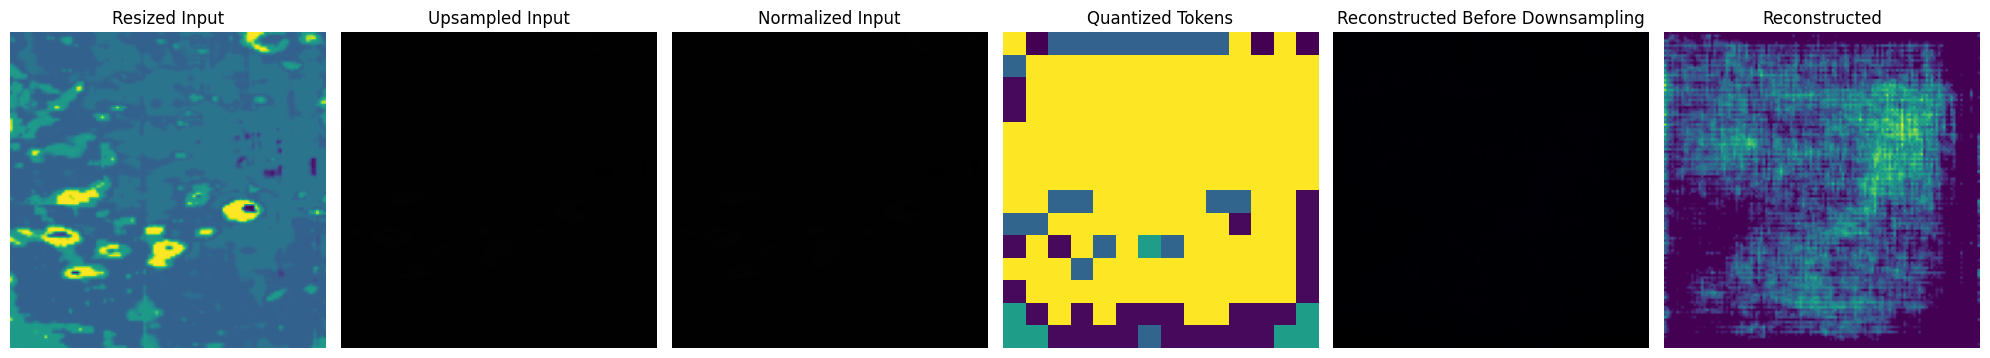

Img Norm


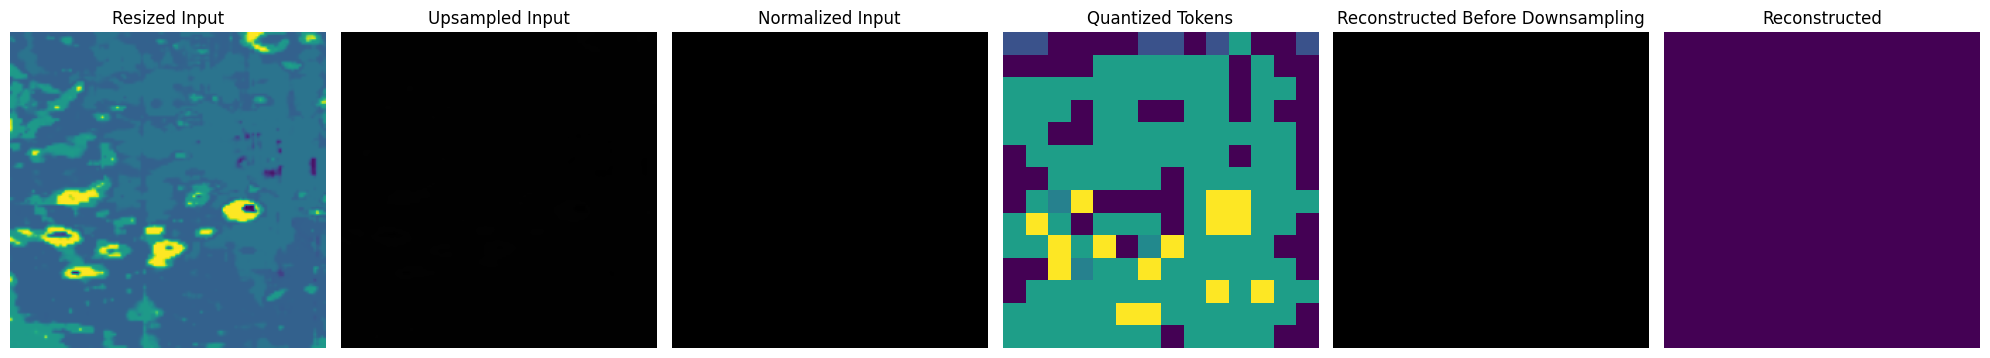

Norm Data No Img Norm


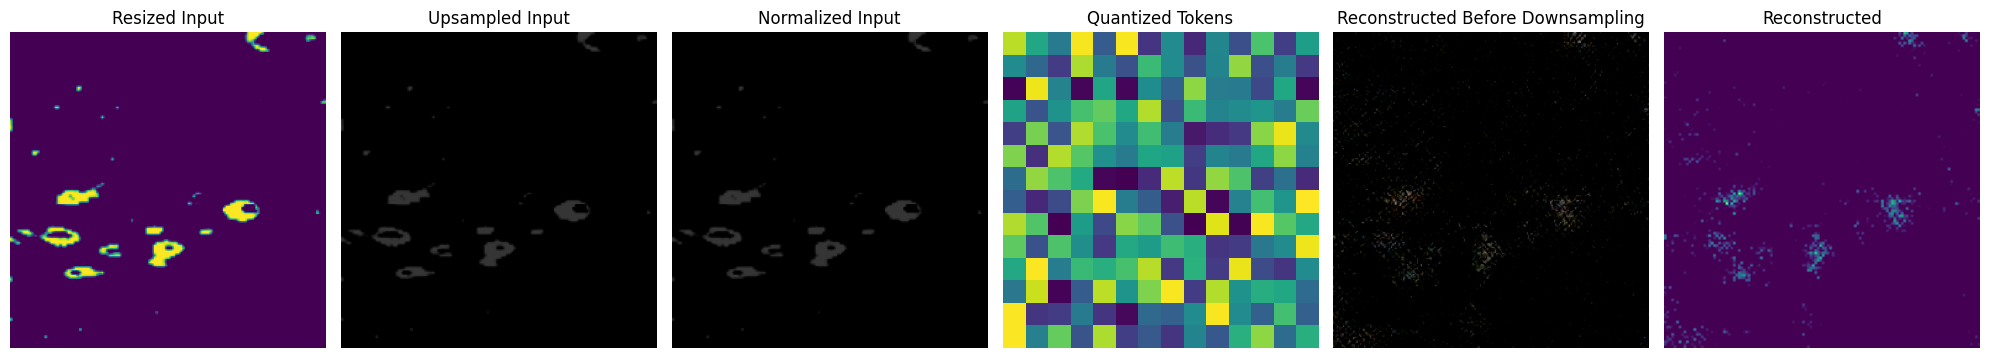

Norm Data Img Norm


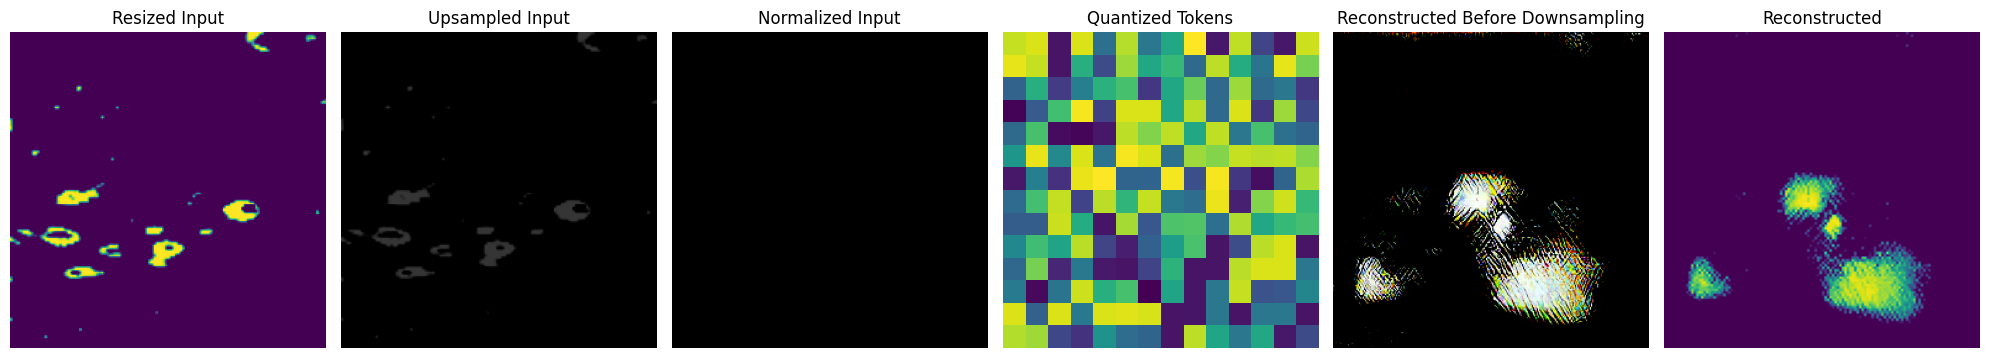

In [76]:
i = 5000
with torch.no_grad():
    print('No Img Norm')
    model.forward_with_visualization(dataset[i][0].unsqueeze(0).cuda(),dataset[i][1].cuda(),norm=False)
    print('Img Norm')
    model.forward_with_visualization(dataset[i][0].unsqueeze(0).cuda(),dataset[i][1].cuda(),norm=True)
    print('Norm Data No Img Norm')
    model.forward_with_visualization(dataset_norm[i][0].unsqueeze(0).cuda(),dataset_norm[i][1].cuda(),norm=False)
    print('Norm Data Img Norm')
    model.forward_with_visualization(dataset_norm[i][0].unsqueeze(0).cuda(),dataset_norm[i][1].cuda(),norm=True)

In [87]:
import torch
import os
from model_spat import SpatialModel  # Ensure this import points to your model class

def load_lightning_checkpoint(
    model, 
    checkpoint_path, 
    map_location=None, 
    strict=False,  # Set to False for flexible loading
    use_percept=False  # Pass this based on your config
):
    """
    Load a checkpoint saved by PyTorch Lightning with advanced key mapping to match model's state dict.

    Args:
        model (torch.nn.Module): The PyTorch model to load state dict into.
        checkpoint_path (str): Path to the PyTorch Lightning checkpoint file.
        map_location (str or torch.device, optional): Specifies how to remap storage locations.
        strict (bool, optional): Whether to strictly enforce key matching. Defaults to False.
        use_percept (bool, optional): Whether perceptual loss is used. Defaults to False.

    Returns:
        torch.nn.Module: The model with loaded weights.
    """
    try:
        # Validate checkpoint path
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_path}")
        
        # Load the checkpoint with weights_only=True if possible to avoid FutureWarning
        # Ensure your PyTorch version supports weights_only
        checkpoint = torch.load(checkpoint_path, map_location=map_location, weights_only=True)
        
        # Extract the state dict
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
        else:
            state_dict = checkpoint
        
        # Get the model's current state dict keys
        model_keys = set(model.state_dict().keys())
        cleaned_state_dict = {}
        unmatched_keys = []
        missing_keys = []
        ignored_keys = []
        
        # Define a mapping dictionary for key prefixes
        prefix_mapping = {
            "model.divae.encoder": "perceptloss.model" if use_percept else "divae.encoder",
            "model.divae.decoder": "perceptloss.feature_extractor" if use_percept else "divae.decoder",
            "divae.encoder": "perceptloss.model" if use_percept else "divae.encoder",
            "divae.decoder": "perceptloss.feature_extractor" if use_percept else "divae.decoder"
        }
        
        # Key remapping logic
        for k, v in state_dict.items():
            cleaned_key = k
            for old_prefix, new_prefix in prefix_mapping.items():
                if k.startswith(old_prefix):
                    cleaned_key = k.replace(old_prefix, new_prefix, 1)
                    break  # Stop after the first matching prefix
            
            # Check if the cleaned key exists in the model's keys
            if cleaned_key in model_keys:
                cleaned_state_dict[cleaned_key] = v
            else:
                # Optionally, handle nested or partial matches
                # For simplicity, we'll mark them as unexpected
                unmatched_keys.append(k)
        
        # Log unmatched keys for debugging
        if unmatched_keys:
            print("\n=== Unmatched Keys in Checkpoint ===")
            for key in unmatched_keys:
                print(f"- {key}")
            print("====================================\n")
        
        # Attempt to load the state dictionary into the model
        try:
            load_result = model.load_state_dict(cleaned_state_dict, strict=strict)
            if load_result.missing_keys:
                missing_keys.extend(load_result.missing_keys)
            if load_result.unexpected_keys:
                ignored_keys.extend(load_result.unexpected_keys)
        except RuntimeError as e:
            print("Error during state_dict loading:", e)
            print("\nModel expected keys:", model_keys)
            print("\nCheckpoint provided keys:", list(cleaned_state_dict.keys()))
            raise ValueError(f"Failed to load state dict: {e}")
        
        # Log missing and ignored keys
        if missing_keys:
            print("\n=== Missing Keys in Checkpoint ===")
            for key in missing_keys:
                print(f"- {key}")
            print("====================================\n")
        
        if ignored_keys:
            print("\n=== Ignored Keys (Not in Model) ===")
            for key in ignored_keys:
                print(f"- {key}")
            print("====================================\n")
        
        # Set the model to evaluation mode
        model.eval()
        return model
    
    except Exception as e:
        print(f"Error loading PyTorch Lightning checkpoint: {e}")
        raise

# Utility function for model loading
def load_model(model, checkpoint_path, use_percept=False):
    """
    Wrapper function to load a model from a checkpoint.

    Args:
        model (torch.nn.Module): The model to load weights into.
        checkpoint_path (str): Path to the checkpoint file.
        use_percept (bool): Whether perceptual loss is used.

    Returns:
        torch.nn.Module: The model with loaded weights.
    """
    return load_lightning_checkpoint(
        model=model, 
        checkpoint_path=checkpoint_path,
        map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        strict=False,  # Allow partial loading
        use_percept=use_percept
    )


In [ ]:
import torch
import os

def load_lightning_checkpoint(
    model, 
    checkpoint_path, 
    map_location=None, 
    strict=False,  # Set to False for flexible loading
    use_percept=False  # Pass this based on your config
):
    """
    Load a checkpoint saved by PyTorch Lightning with advanced key mapping to match model's state dict.
    """
    try:
        print(f"Loading checkpoint from: {checkpoint_path}")
        # Validate checkpoint path
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_path}")
        
        # Load the checkpoint with weights_only=True if possible to avoid FutureWarning
        # Ensure your PyTorch version supports weights_only
        checkpoint = torch.load(checkpoint_path, map_location=map_location, weights_only=True)
        
        # Extract the state dict
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
        else:
            state_dict = checkpoint
        
        # Get the model's current state dict keys
        model_keys = set(model.state_dict().keys())
        cleaned_state_dict = {}
        unmatched_keys = []
        
        # Define a mapping dictionary for key prefixes
        prefix_mapping = {
            "model.divae.encoder": "perceptloss.model" if use_percept else "divae.encoder",
            "model.divae.decoder": "perceptloss.feature_extractor" if use_percept else "divae.decoder",
            "divae.encoder": "perceptloss.model" if use_percept else "divae.encoder",
            "divae.decoder": "perceptloss.feature_extractor" if use_percept else "divae.decoder",
            "model.divae.quant_proj": "divae.quant_proj",
            "model.divae.quantize": "divae.quantize",
            # Add more mappings as necessary
        }
        
        # Key remapping logic
        for k, v in state_dict.items():
            cleaned_key = k
            for old_prefix, new_prefix in prefix_mapping.items():
                if k.startswith(old_prefix):
                    # Replace only the prefix
                    cleaned_key = k.replace(old_prefix, new_prefix, 1)
                    break  # Stop after the first matching prefix
            
            # Check if the cleaned key exists in the model's keys
            if cleaned_key in model_keys:
                cleaned_state_dict[cleaned_key] = v
            else:
                # Mark them as unexpected
                unmatched_keys.append(k)
        
        # Log unmatched keys for debugging
        if unmatched_keys:
            print("\n=== Unmatched Keys in Checkpoint ===")
            for key in unmatched_keys:
                print(f"- {key}")
            print("====================================\n")
        
        # Attempt to load the state dictionary into the model
        try:
            load_result = model.load_state_dict(cleaned_state_dict, strict=strict)
            if load_result.missing_keys:
                missing_keys = load_result.missing_keys
                print("\n=== Missing Keys in Checkpoint ===")
                for key in missing_keys:
                    print(f"- {key}")
                print("====================================\n")
            if load_result.unexpected_keys:
                ignored_keys = load_result.unexpected_keys
                print("\n=== Ignored Keys (Not in Model) ===")
                for key in ignored_keys:
                    print(f"- {key}")
                print("====================================\n")
        except RuntimeError as e:
            print("Error during state_dict loading:", e)
            print("\nModel expected keys:", model_keys)
            print("\nCheckpoint provided keys:", list(cleaned_state_dict.keys()))
            raise ValueError(f"Failed to load state dict: {e}")
        
        print("Checkpoint loaded and state_dict updated.")
        
        # Set the model to evaluation mode
        model.eval()
        return model
    
    except Exception as e:
        print(f"Error loading PyTorch Lightning checkpoint: {e}")
        raise

# Wrapper function for model loading
def load_model(model, checkpoint_path, use_percept=False):
    """
    Wrapper function to load a model from a checkpoint.
    """
    return load_lightning_checkpoint(
        model=model, 
        checkpoint_path=checkpoint_path,
        map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        strict=False,  # Allow partial loading
        use_percept=use_percept
    )

# Helper function to inspect checkpoint keys
def compare_state_dict_keys(checkpoint_path):
    """
    Print out the keys from a checkpoint for debugging.
    """
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
    if 'state_dict' in checkpoint:
        keys = checkpoint['state_dict'].keys()
        print("Keys from 'state_dict':")
    elif 'model' in checkpoint:
        keys = checkpoint['model'].keys()
        print("Keys from 'model':")
    else:
        keys = checkpoint.keys()
        print("Keys from direct checkpoint:")
    
    for key in keys:
        print(key)

# Function to load YAML config
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Example usage
if __name__ == "__main__":
    config_path = '/home/kraju_umass_edu/Tokenizer/H3Tokenizer/config_ca_diffusion.yaml'  # Path to your YAML config
    config = load_config(config_path)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    spatmodel = SpatialModel(config).to(device)
    spatmodel.eval()  # Set the model to evaluation mode
    
    # Load the model from the checkpoint
    checkpoint_path = '/home/kraju_umass_edu/Tokenizer/H3Tokenizer/v1/Global20ppd_MLR_LPGRS_geotiffCa_tokens_lr1e4/mae-epoch=22-val_loss=0.00.ckpt'
    loaded_model = load_model(
        model=spatmodel, 
        checkpoint_path=checkpoint_path,
        use_percept=config['loss']['use_percept']
    )


Loading pretrained DiVAE model from: EPFL-VILAB/4M_tokenizers_rgb_16k_224-448


Loaded Configuration:
data:
  file: Global20ppd_MLR_LPGRS_geotiffCa.npy
  folder: false
  name: geochemical_maps
  num_workers: 10
  pin_mem: false
  root: /work/pi_mparente_umass_edu/data/NormalizedLunarData/
debug: false
loss:
  feature_ids: blocks.2-blocks.5-blocks.8-blocks.11
  model_id: vit_base_patch16_224_dino
  norm_pix_loss: false
  use_percept: false
mlp_ratio: 4
model:
  ckpt: /home/kraju_umass_edu/Tokenizer/H3Tokenizer/models/hypersigma_weights/spat-vit-base-ultra-checkpoint-1599.pth
  drop_path_rate: 0.0
  enc_dim: 768
  enc_mask: 0.0
  image_size: 256
  mask_ratio: 0.0
  num_channels: 1
  num_tokens: 36
  out_conv: true
  out_conv_type: 1
  patch_size: 16
  scheduler_type: ddim
  spat_spec: false
  use_ckpt: true
  use_diffusion: true
output:
  dir: ./v1/Global20ppd_MLR_LPGRS_geotiffCa_tokens_lr1e4/
  log_dir: ./v1/log_dir/Global20ppd_MLR_LPGRS_geotiffCa_tokens_lr1e4/
post_mlp: false
quantizer:
  code_replacement_policy: batch_random
  codebook_size: 8192
  commitment_wei

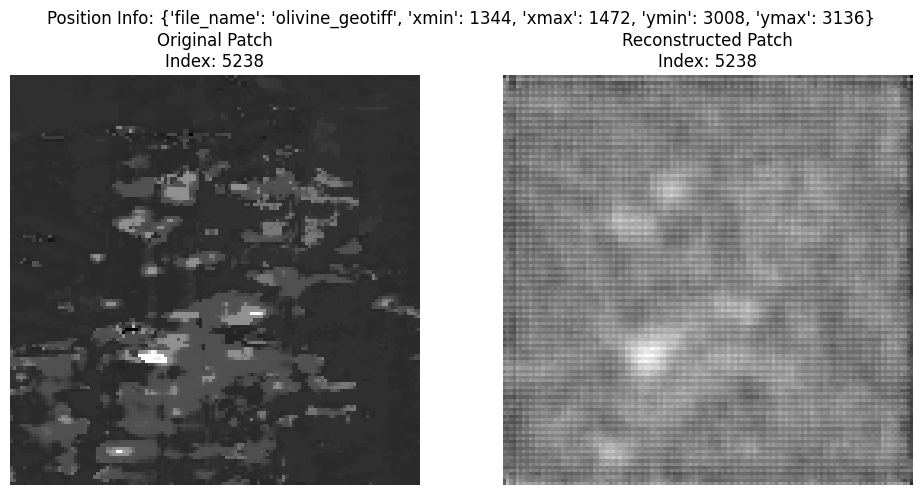


--- Index: 912 ---
Reconstructed Output Type: <class 'tuple'>
Reconstructed Output Length: 7
Output[0] Shape: torch.Size([1])
Output[1] Shape: torch.Size([])
Output[2] Type: <class 'float'>
Output[3] Shape: torch.Size([1])
Output[4] Type: <class 'NoneType'>
Output[5] Shape: torch.Size([1, 1, 128, 128])
Output[6] Type: <class 'NoneType'>
Using reconstructed_output[5] as reconstructed_patch with shape torch.Size([1, 1, 128, 128])


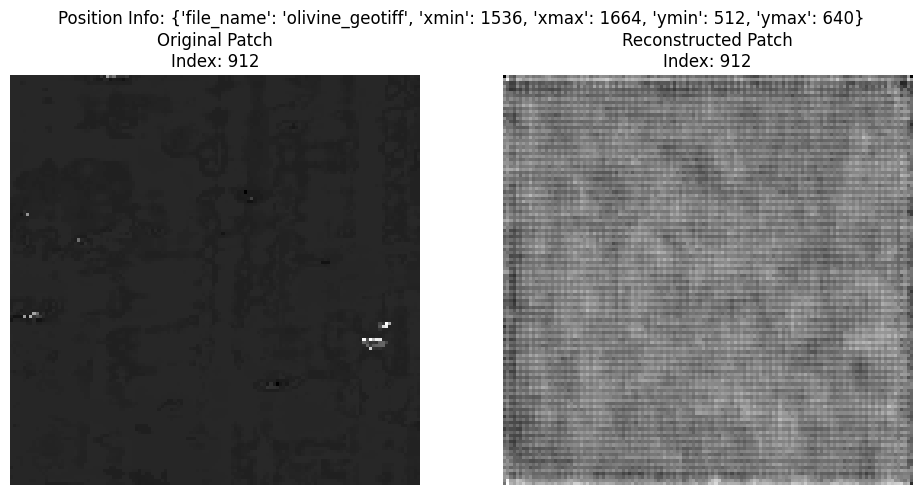


--- Index: 204 ---
Reconstructed Output Type: <class 'tuple'>
Reconstructed Output Length: 7
Output[0] Shape: torch.Size([1])
Output[1] Shape: torch.Size([])
Output[2] Type: <class 'float'>
Output[3] Shape: torch.Size([1])
Output[4] Type: <class 'NoneType'>
Output[5] Shape: torch.Size([1, 1, 128, 128])
Output[6] Type: <class 'NoneType'>
Using reconstructed_output[5] as reconstructed_patch with shape torch.Size([1, 1, 128, 128])


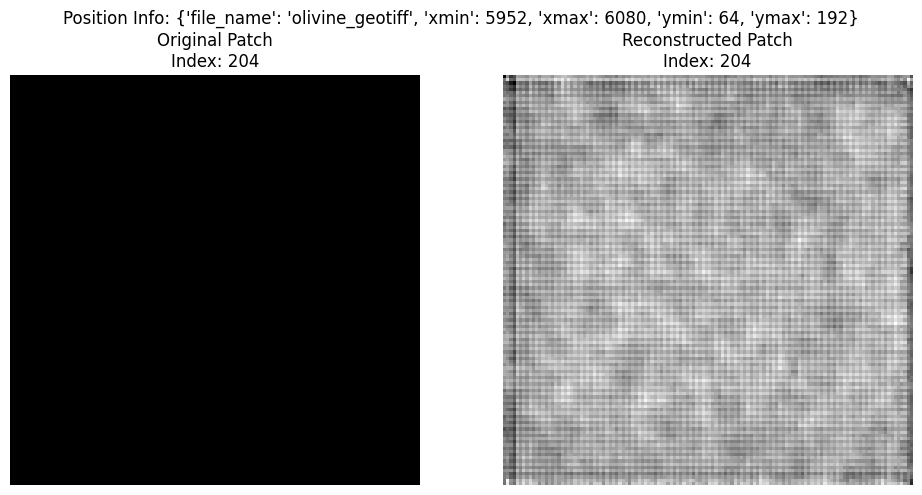


--- Index: 6074 ---
Reconstructed Output Type: <class 'tuple'>
Reconstructed Output Length: 7
Output[0] Shape: torch.Size([1])
Output[1] Shape: torch.Size([])
Output[2] Type: <class 'float'>
Output[3] Shape: torch.Size([1])
Output[4] Type: <class 'NoneType'>
Output[5] Shape: torch.Size([1, 1, 128, 128])
Output[6] Type: <class 'NoneType'>
Using reconstructed_output[5] as reconstructed_patch with shape torch.Size([1, 1, 128, 128])


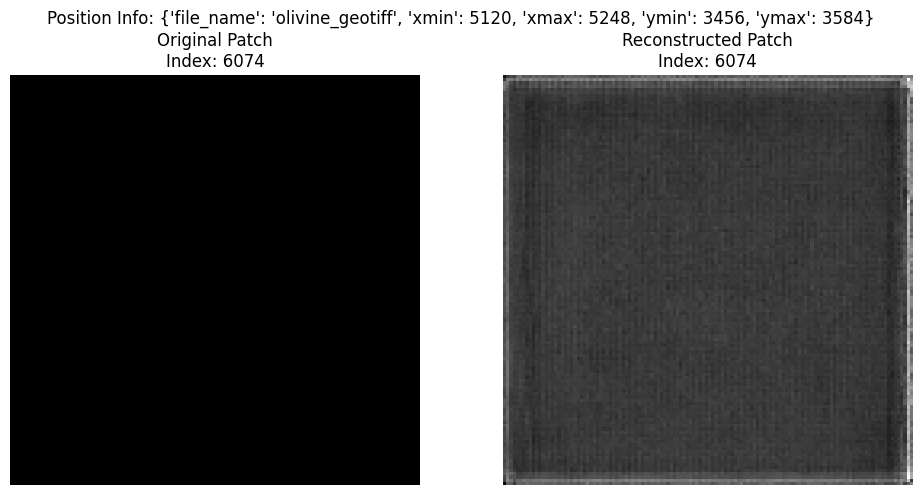


--- Index: 2253 ---
Reconstructed Output Type: <class 'tuple'>
Reconstructed Output Length: 7
Output[0] Shape: torch.Size([1])
Output[1] Shape: torch.Size([])
Output[2] Type: <class 'float'>
Output[3] Shape: torch.Size([1])
Output[4] Type: <class 'NoneType'>
Output[5] Shape: torch.Size([1, 1, 128, 128])
Output[6] Type: <class 'NoneType'>
Using reconstructed_output[5] as reconstructed_patch with shape torch.Size([1, 1, 128, 128])


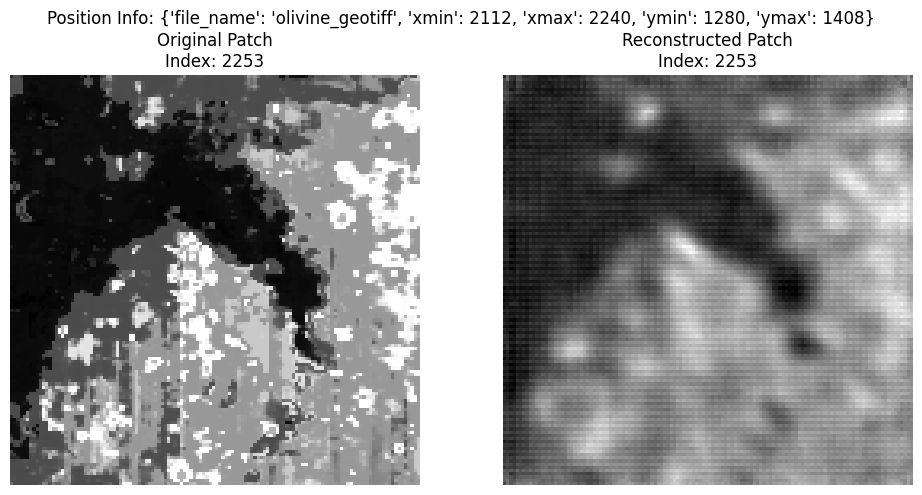


--- Index: 2006 ---
Reconstructed Output Type: <class 'tuple'>
Reconstructed Output Length: 7
Output[0] Shape: torch.Size([1])
Output[1] Shape: torch.Size([])
Output[2] Type: <class 'float'>
Output[3] Shape: torch.Size([1])
Output[4] Type: <class 'NoneType'>
Output[5] Shape: torch.Size([1, 1, 128, 128])
Output[6] Type: <class 'NoneType'>
Using reconstructed_output[5] as reconstructed_patch with shape torch.Size([1, 1, 128, 128])


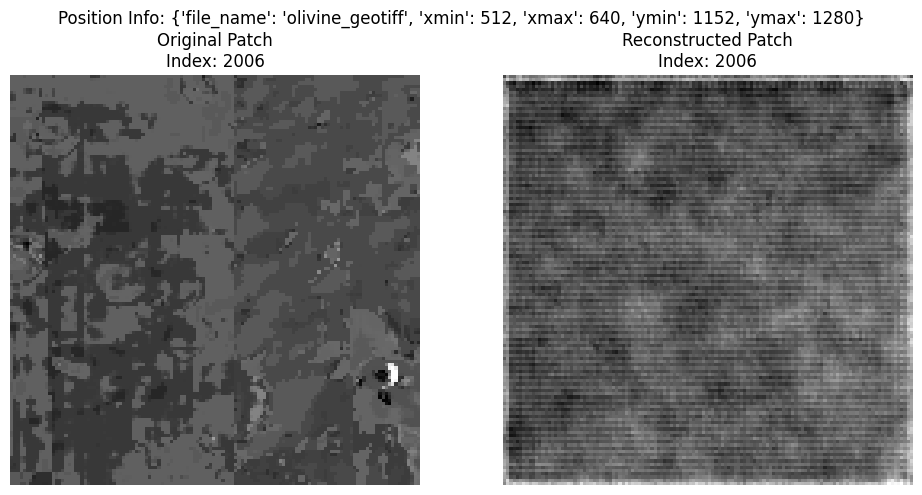


--- Index: 1828 ---
Reconstructed Output Type: <class 'tuple'>
Reconstructed Output Length: 7
Output[0] Shape: torch.Size([1])
Output[1] Shape: torch.Size([])
Output[2] Type: <class 'float'>
Output[3] Shape: torch.Size([1])
Output[4] Type: <class 'NoneType'>
Output[5] Shape: torch.Size([1, 1, 128, 128])
Output[6] Type: <class 'NoneType'>
Using reconstructed_output[5] as reconstructed_patch with shape torch.Size([1, 1, 128, 128])


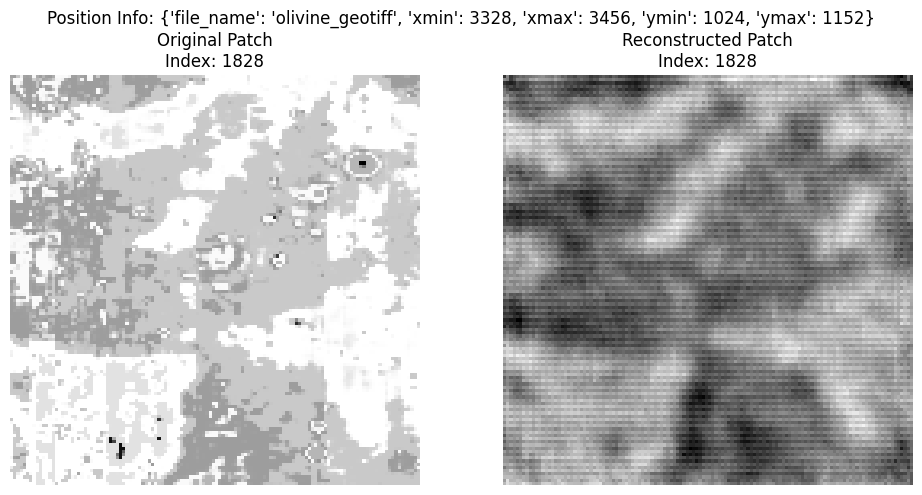


--- Index: 1143 ---
Reconstructed Output Type: <class 'tuple'>
Reconstructed Output Length: 7
Output[0] Shape: torch.Size([1])
Output[1] Shape: torch.Size([])
Output[2] Type: <class 'float'>
Output[3] Shape: torch.Size([1])
Output[4] Type: <class 'NoneType'>
Output[5] Shape: torch.Size([1, 1, 128, 128])
Output[6] Type: <class 'NoneType'>
Using reconstructed_output[5] as reconstructed_patch with shape torch.Size([1, 1, 128, 128])


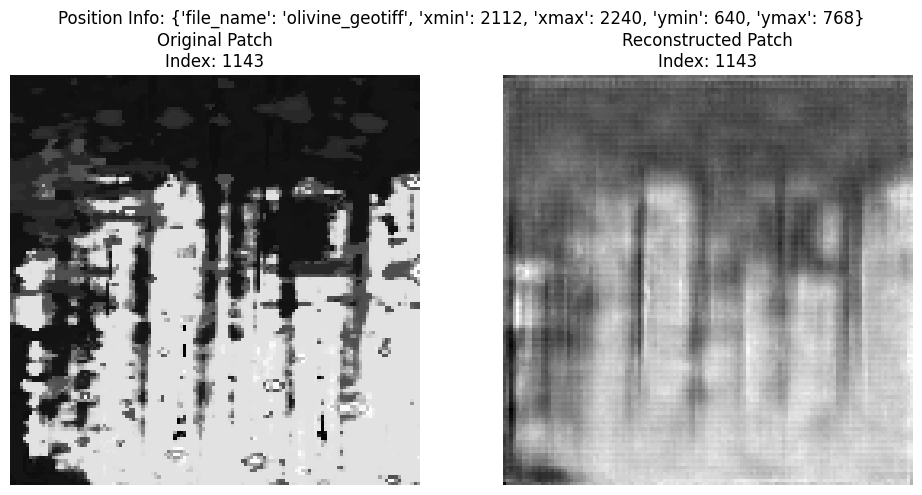


--- Index: 6033 ---
Reconstructed Output Type: <class 'tuple'>
Reconstructed Output Length: 7
Output[0] Shape: torch.Size([1])
Output[1] Shape: torch.Size([])
Output[2] Type: <class 'float'>
Output[3] Shape: torch.Size([1])
Output[4] Type: <class 'NoneType'>
Output[5] Shape: torch.Size([1, 1, 128, 128])
Output[6] Type: <class 'NoneType'>
Using reconstructed_output[5] as reconstructed_patch with shape torch.Size([1, 1, 128, 128])


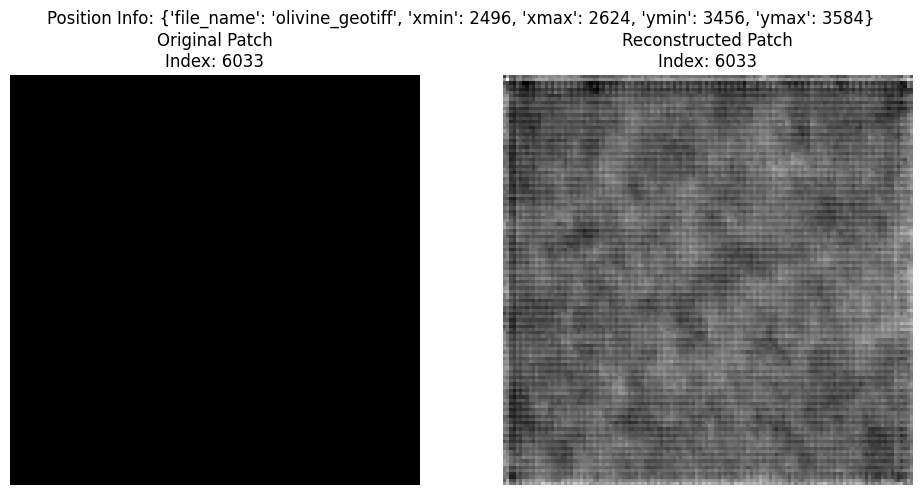


--- Index: 839 ---
Reconstructed Output Type: <class 'tuple'>
Reconstructed Output Length: 7
Output[0] Shape: torch.Size([1])
Output[1] Shape: torch.Size([])
Output[2] Type: <class 'float'>
Output[3] Shape: torch.Size([1])
Output[4] Type: <class 'NoneType'>
Output[5] Shape: torch.Size([1, 1, 128, 128])
Output[6] Type: <class 'NoneType'>
Using reconstructed_output[5] as reconstructed_patch with shape torch.Size([1, 1, 128, 128])


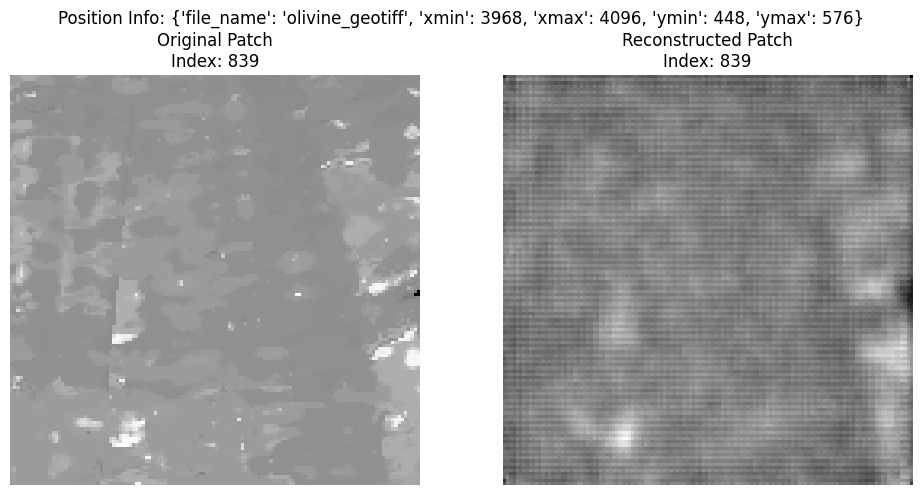

In [6]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
from typing import Dict, List, Tuple, Union
import yaml
import matplotlib.pyplot as plt
import random

# Assuming SpatialModel is correctly defined in model_spat.py
from model_spat import SpatialModel

# ----------------------------
# CubeData Class Definition
# ----------------------------
class CubeData(Dataset):
    """Cube Dataset with Stride-based Patch Extraction and Optional Normalization"""
    def __init__(self, root: str, name: str, patch_size: int = 128, stride: int = 64, 
                 transform=None, folder=True, file=None, apply_normalization=True) -> None:
        """
        Create a dataset from a given directory with stride-based patch extraction.
        """
        super().__init__()
        self.transform = transform
        self.root = root
        self.name = name
        self.patch_size = patch_size
        self.stride = stride
        self.apply_normalization = apply_normalization

        # Handle both folder and single file cases
        if folder:
            self.cubeFileNames = [f for f in os.listdir(os.path.join(self.root, name, "python")) 
                                if ".npy" in f]
        else:
            if file is None:
                raise ValueError("When folder=False, a file name must be provided!")
            self.cubeFileNames = [file]

        if len(self.cubeFileNames) == 0:
            raise ValueError("Couldn't find any numpy files in the given folder!")

        self.cubes = self.__load_cubes()
        self.patches, self.patch_positions = self.__extract_patches()
        self.file_patch_mapping = self.__create_file_patch_mapping()
        
        # Compute mean and std for normalization
        if self.apply_normalization:
            self.mean, self.std = self.__compute_mean_and_std()
            print(f"Dataset mean: {self.mean}")
            print(f"Dataset std: {self.std}")
        else:
            self.mean, self.std = None, None

    def __compute_mean_and_std(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute mean and standard deviation directly from patches.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean and standard deviation for each channel
        """
        patches_tensor = torch.stack([torch.from_numpy(patch) for patch in self.patches])
        mean = patches_tensor.mean(dim=(0, 2, 3))
        std = patches_tensor.std(dim=(0, 2, 3), unbiased=False)
        return mean, std

    def __load_and_reshape(self, file_path):
        """Load and reshape the cube data to ensure proper dimensionality."""
        current_cube = np.load(file_path)
        if current_cube.ndim == 2:
            current_cube = np.expand_dims(current_cube, axis=0).astype(np.float32)
        return current_cube

    def __load_cubes(self) -> Dict[str, np.ndarray]:
        """Loads all cubes contained in the folder and stores them in a dictionary indexed by filename."""
        cubes = {}
        total_size = 0
        for file in self.cubeFileNames:
            file_path = os.path.join(self.root, self.name, "python", file)
            current_cube = self.__load_and_reshape(file_path)
            fileName = file.split('.')[0]
            cubes[fileName] = current_cube
            total_size += current_cube.nbytes
        print(f"Total size of loaded cubes: {total_size / (1024**3):.2f} GB")
        return cubes

    def __extract_patches(self):
        """Extract patches from each cube using the specified patch size and stride."""
        patches = []
        patch_positions = []
        for file_name, cube in self.cubes.items():
            c, H, W = cube.shape
            for i in range(0, H - self.patch_size + 1, self.stride):
                for j in range(0, W - self.patch_size + 1, self.stride):
                    patch = cube[:, i:i+self.patch_size, j:j+self.patch_size]
                    patches.append(patch)
                    patch_positions.append((file_name, j, j+self.patch_size, i, i+self.patch_size))
        return patches, patch_positions

    def __create_file_patch_mapping(self):
        """Creates a mapping of which patches belong to which file."""
        mapping = {}
        for idx, (file_name, _, _, _, _) in enumerate(self.patch_positions):
            if file_name not in mapping:
                mapping[file_name] = []
            mapping[file_name].append(idx)
        return mapping

    def __len__(self) -> int:
        """Returns the total number of patches."""
        return len(self.patches)

    def __normalize(self, patch: torch.Tensor) -> torch.Tensor:
        """Normalize the patch using computed mean and std."""
        if self.apply_normalization:
            return (patch - self.mean[:, None, None]) / (self.std[:, None, None] + 1e-8)
        return patch

    def __getitem__(self, index: Union[int, List[int], slice]) -> Tuple[torch.Tensor, torch.Tensor, Union[Dict, List[Dict]]]:
        """
        Returns normalized patch(es), corresponding mask(s), and position information.
        """
        if isinstance(index, (torch.Tensor, np.ndarray)):
            index = index.tolist()

        if isinstance(index, int):
            patch = torch.from_numpy(self.patches[index].copy())
            position_info = {
                'file_name': self.patch_positions[index][0],
                'xmin': self.patch_positions[index][1],
                'xmax': self.patch_positions[index][2],
                'ymin': self.patch_positions[index][3],
                'ymax': self.patch_positions[index][4]
            }
            
        elif isinstance(index, list):
            patch = torch.stack([torch.from_numpy(self.patches[i].copy()) for i in index])
            position_info = [{
                'file_name': self.patch_positions[i][0],
                'xmin': self.patch_positions[i][1],
                'xmax': self.patch_positions[i][2],
                'ymin': self.patch_positions[i][3],
                'ymax': self.patch_positions[i][4]
            } for i in index]
            
        elif isinstance(index, slice):
            indices = range(index.start or 0, index.stop or len(self), index.step or 1)
            patch = torch.stack([torch.from_numpy(self.patches[i].copy()) for i in indices])
            position_info = [{
                'file_name': self.patch_positions[i][0],
                'xmin': self.patch_positions[i][1],
                'xmax': self.patch_positions[i][2],
                'ymin': self.patch_positions[i][3],
                'ymax': self.patch_positions[i][4]
            } for i in indices]

        patch = self.__normalize(patch)

        if self.transform:
            patch = self.transform(patch)

        mask = self.__computeMask(patch).to(torch.bool)
        patch = torch.nan_to_num(patch, nan=0.0)
        
        return patch, mask, position_info

    def __computeMask(self, img: torch.Tensor) -> torch.Tensor:
        """Computes a binary mask for a given patch."""
        mask = torch.zeros_like(img)
        mask[torch.where(img == 0)] = 1.0
        if torch.isnan(img).any():
            mask[torch.isnan(img)] = 1.0
        if len(img.shape) == 3:
            c, h, w = img.shape
            summed = torch.sum(mask, dim=0)
            mask = (summed == c).unsqueeze(0).float()
        else:
            n, c, h, w = img.shape
            summed = torch.sum(mask, dim=1)
            mask = (summed == c).unsqueeze(1).float()
        return mask

    def get_patches_for_file(self, file_name: str) -> List[int]:
        """Returns indices of all patches that belong to a specific file."""
        file_name = file_name.replace('.npy', '')
        return self.file_patch_mapping.get(file_name, [])

# ----------------------------
# Load Configuration and Initialize Dataset
# ----------------------------
def load_config(config_path):
    """
    Load YAML configuration file.

    Args:
        config_path (str): Path to the YAML config file.

    Returns:
        Dict: Configuration dictionary.
    """
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# ----------------------------
# Visualization Function (Updated to Handle Model's Tuple Output)
# ----------------------------
def visualize_reconstructions(dataset, model, indices, device='cuda'):
    """
    Visualize original and reconstructed patches from the dataset.

    Args:
        dataset (Dataset): The CubeData dataset.
        model (torch.nn.Module): The pretrained SpatialModel.
        indices (List[int]): List of indices to visualize.
        device (str): Device to perform computation on ('cuda' or 'cpu').
    """
    # Disable gradient calculations for inference
    with torch.no_grad():
        for idx in indices:
            # Retrieve the patch, mask, and position info
            patch, mask, pos_info = dataset[idx]

            # Prepare the input tensor (add batch dimension and move to device)
            input_patch = patch.unsqueeze(0).to(device)

            # Pass the patch through the model to get the reconstructed patch
            try:
                reconstructed_output = model(input_patch)
            except Exception as e:
                print(f"Error during model inference for index {idx}: {e}")
                continue

            # Debugging: Print output type and shape
            print(f"\n--- Index: {idx} ---")
            print(f"Reconstructed Output Type: {type(reconstructed_output)}")
            
            if isinstance(reconstructed_output, tuple):
                print(f"Reconstructed Output Length: {len(reconstructed_output)}")
                for i, item in enumerate(reconstructed_output):
                    if isinstance(item, torch.Tensor):
                        print(f"Output[{i}] Shape: {item.shape}")
                    else:
                        print(f"Output[{i}] Type: {type(item)}")
            elif isinstance(reconstructed_output, torch.Tensor):
                print(f"Reconstructed Output Shape: {reconstructed_output.shape}")
            else:
                print(f"Unexpected output type: {type(reconstructed_output)}")
            
            # Handle tuple outputs
            if isinstance(reconstructed_output, tuple):
                # Assuming the 6th element (index 5) is the reconstructed patch
                try:
                    reconstructed_patch = reconstructed_output[5]
                    print(f"Using reconstructed_output[5] as reconstructed_patch with shape {reconstructed_patch.shape}")
                except IndexError:
                    print(f"Output tuple does not have index 5. Skipping index {idx}.")
                    continue
            elif isinstance(reconstructed_output, torch.Tensor):
                reconstructed_patch = reconstructed_output
                print(f"Using reconstructed_output as reconstructed_patch with shape {reconstructed_patch.shape}")
            else:
                print(f"Skipping index {idx} due to unexpected output type.")
                continue

            # Check if reconstructed_patch has at least one dimension
            if reconstructed_patch.dim() == 0:
                print(f"Reconstructed patch for index {idx} is 0-dimensional. Skipping visualization.")
                continue

            # Move the reconstructed patch to CPU and remove batch dimension
            try:
                reconstructed_patch = reconstructed_patch.squeeze(0).cpu()
            except Exception as e:
                print(f"Error squeezing reconstructed_patch for index {idx}: {e}")
                continue

            # Convert tensors to NumPy arrays for plotting
            original_np = patch.numpy()
            reconstructed_np = reconstructed_patch.numpy()

            # Handle multi-channel (e.g., RGB) and single-channel (grayscale) images
            if original_np.shape[0] == 1:
                original_image = original_np[0]  # Shape: (H, W)
                if reconstructed_np.ndim == 0:
                    print(f"Reconstructed image for index {idx} is 0-dimensional after squeezing. Skipping visualization.")
                    continue
                reconstructed_image = reconstructed_np[0]  # Shape: (H, W)
                cmap = 'gray'
            elif len(original_np.shape) == 3 and original_np.shape[0] in [1, 3]:
                # Assuming channel-first format
                original_image = np.transpose(original_np, (1, 2, 0))  # Shape: (H, W, C)
                reconstructed_image = np.transpose(reconstructed_np, (1, 2, 0))  # Shape: (H, W, C)
                cmap = None  # Default colormap for RGB
            else:
                print(f"Unexpected original_np shape for index {idx}: {original_np.shape}. Skipping visualization.")
                continue

            # Create subplots
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            # Plot Original Patch
            axs[0].imshow(original_image, cmap=cmap)
            axs[0].set_title(f"Original Patch\nIndex: {idx}")
            axs[0].axis('off')

            # Plot Reconstructed Patch
            axs[1].imshow(reconstructed_image, cmap=cmap)
            axs[1].set_title(f"Reconstructed Patch\nIndex: {idx}")
            axs[1].axis('off')

            # Add overall title with position information
            plt.suptitle(f"Position Info: {pos_info}", fontsize=12)

            # Display the plots
            plt.tight_layout()
            plt.show()

# ----------------------------
# Load Checkpoint Function
# ----------------------------
def load_lightning_checkpoint(
    model, 
    checkpoint_path, 
    map_location=None, 
    strict=False,  # Set to False for flexible loading
    use_percept=False  # Pass this based on your config
):
    """
    Load a checkpoint saved by PyTorch Lightning with advanced key mapping to match model's state dict.
    """
    try:
        print(f"Loading checkpoint from: {checkpoint_path}")
        # Validate checkpoint path
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_path}")
        
        # Load the checkpoint with weights_only=True to load only model weights
        checkpoint = torch.load(checkpoint_path, map_location=map_location, weights_only=True)
        
        # Extract the state dict
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
        else:
            state_dict = checkpoint
        
        # Get the model's current state dict keys
        model_keys = set(model.state_dict().keys())
        cleaned_state_dict = {}
        unmatched_keys = []
        
        # Define a mapping dictionary for key prefixes
        prefix_mapping = {
            "model.divae.encoder": "perceptloss.model" if use_percept else "divae.encoder",
            "model.divae.decoder": "perceptloss.feature_extractor" if use_percept else "divae.decoder",
            "divae.encoder": "perceptloss.model" if use_percept else "divae.encoder",
            "divae.decoder": "perceptloss.feature_extractor" if use_percept else "divae.decoder",
            "model.divae.quant_proj": "divae.quant_proj",
            "model.divae.quantize": "divae.quantize",
            "model.divae.quantize._codebook": "divae.quantize._codebook",
            # Add more mappings as necessary
        }
        
        # Key remapping logic
        for k, v in state_dict.items():
            cleaned_key = k
            for old_prefix, new_prefix in prefix_mapping.items():
                if k.startswith(old_prefix):
                    # Replace only the prefix
                    cleaned_key = k.replace(old_prefix, new_prefix, 1)
                    break  # Stop after the first matching prefix
            
            # Check if the cleaned key exists in the model's keys
            if cleaned_key in model_keys:
                cleaned_state_dict[cleaned_key] = v
            else:
                # Mark them as unexpected
                unmatched_keys.append(k)
        
        # Log unmatched keys for debugging
        if unmatched_keys:
            print("\n=== Unmatched Keys in Checkpoint ===")
            for key in unmatched_keys:
                print(f"- {key}")
            print("====================================\n")
        
        # Attempt to load the state dictionary into the model
        try:
            load_result = model.load_state_dict(cleaned_state_dict, strict=strict)
            if load_result.missing_keys:
                missing_keys = load_result.missing_keys
                print("\n=== Missing Keys in Checkpoint ===")
                for key in missing_keys:
                    print(f"- {key}")
                print("====================================\n")
            if load_result.unexpected_keys:
                ignored_keys = load_result.unexpected_keys
                print("\n=== Ignored Keys (Not in Model) ===")
                for key in ignored_keys:
                    print(f"- {key}")
                print("====================================\n")
        except RuntimeError as e:
            print("Error during state_dict loading:", e)
            print("\nModel expected keys:", model_keys)
            print("\nCheckpoint provided keys:", list(cleaned_state_dict.keys()))
            raise ValueError(f"Failed to load state dict: {e}")
        
        print("Checkpoint loaded and state_dict updated.")
        
        # Set the model to evaluation mode
        model.eval()
        return model
    
    except Exception as e:
        print(f"Error loading PyTorch Lightning checkpoint: {e}")
        raise

# Wrapper function for model loading
def load_model(model, checkpoint_path, use_percept=False):
    """
    Wrapper function to load a model from a checkpoint.
    """
    return load_lightning_checkpoint(
        model=model, 
        checkpoint_path=checkpoint_path,
        map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        strict=False,  # Allow partial loading
        use_percept=use_percept
    )

# ----------------------------
# Main Execution Block
# ----------------------------
if __name__ == "__main__":
    # Path to your YAML configuration file
    config_path = '/home/kraju_umass_edu/Tokenizer/H3Tokenizer/config_ca_diffusion.yaml'  # Adjust as needed

    # Load configuration
    config = load_config(config_path)
    print("Loaded Configuration:")
    print(yaml.dump(config, default_flow_style=False))
    
    # Initialize the dataset
    dataset = CubeData(
        root="/work/pi_mparente_umass_edu/data/NormalizedLunarData/",
        name="mineral_abundance",
        patch_size=128,
        stride=64,
        folder=False,
        file='olivine_geotiff.npy',
        apply_normalization=False  # Set to True if the model expects normalized inputs
    )
    
    # Initialize the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    spatmodel = SpatialModel(config).to(device)
    spatmodel.eval()  # Set the model to evaluation mode
    
    # Path to your checkpoint
    checkpoint_path = '/home/kraju_umass_edu/Tokenizer/H3Tokenizer/v1/Global20ppd_MLR_LPGRS_geotiffCa_tokens_lr1e4/mae-epoch=22-val_loss=0.00.ckpt'
    
    # Load the model weights from the checkpoint
    loaded_model = load_model(
        model=spatmodel, 
        checkpoint_path=checkpoint_path,
        use_percept=config['loss']['use_percept']
    )
    
    # Verify the loaded model (optional)
    print("\nModel's state_dict keys after loading checkpoint:")
    for key in loaded_model.state_dict().keys():
        print(key)
    
    # Select 10 unique sample indices
    num_samples = 10
    random.seed(42)  # For reproducibility
    sample_indices = random.sample(range(len(dataset)), num_samples)
    
    # Visualize the reconstructions
    visualize_reconstructions(dataset, loaded_model, sample_indices, device=device)
